In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pathlib
import PIL
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
print('Loaded')

Loaded


## Import the dataset

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
print(data_dir)

/home/saksevul/.keras/datasets/flower_photos


/home/saksevul/.keras/datasets/flower_photos/roses/2183357362_4b4da4b6b5.jpg


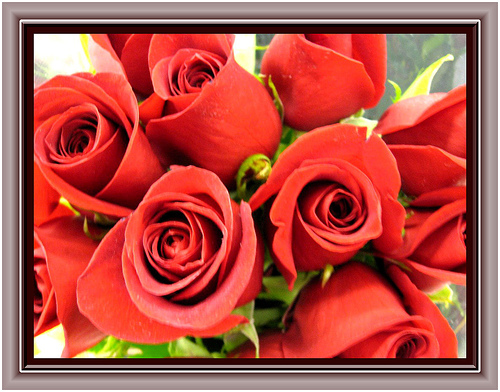

In [32]:
roses = list(data_dir.glob('roses/*'))
print(roses[7])
PIL.Image.open(str(roses[7]))

## Split the data

In [4]:
# porcin de datos de entrenamiento
p = 0.6

img_height,img_width=180,180
batch_size=32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=p,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)
print(type(train_ds))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=p,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)
print(train_ds[:5])

Found 3670 files belonging to 5 classes.
Using 1468 files for training.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Found 3670 files belonging to 5 classes.
Using 2202 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2022-04-22 11:40:14.684128: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-22 11:40:14.685334: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-22 11:40:14.687604: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


TypeError: 'BatchDataset' object is not subscriptable

## Visualize your data

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


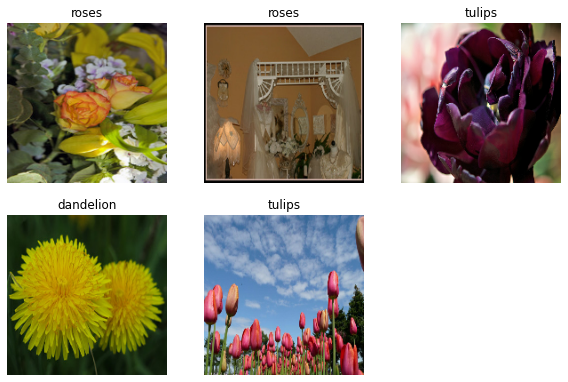

In [87]:
plt.figure(figsize=(10, 10))
print(class_names)
for images, labels in train_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        c = np.array(labels)[i]
        cl = int(0*c[0] + 1*c[1] + 2*c[2] + 3*c[3] + 4*c[4])
        plt.title(str(class_names[cl]))
        plt.axis("off")

## Import the pre-trained model

In [8]:
resnet_model = Sequential()

# excluimos el top de la red para no tener problemas con la dimension de las imagenes
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
# no se entrenan las capas internas del modelo de transfer learning 
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
# capas adicionales en la red, estas serán entrenadas
resnet_model.add(Dense(512, activation='relu'))
# capa final con el número de clases
resnet_model.add(Dense(5, activation='softmax'))

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________


## Compile the model

In [9]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy', metrics.Precision(), metrics.Recall()])

epochs=10

history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 114s 1s/step - loss: 1.4546 - accuracy: 0.6442 - precision: 0.6791 - recall: 0.6091 - val_loss: 0.3702 - val_accuracy: 0.8474 - val_precision: 0.8932 - val_recall: 0.8202
Epoch 2/10
92/92 [==============================] - 114s 1s/step - loss: 0.2904 - accuracy: 0.8985 - precision: 0.9157 - recall: 0.8767 - val_loss: 0.3669 - val_accuracy: 0.8651 - val_precision: 0.8837 - val_recall: 0.8488
Epoch 3/10
92/92 [==============================] - 114s 1s/step - loss: 0.1903 - accuracy: 0.9288 - precision: 0.9400 - recall: 0.9176 - val_loss: 0.3979 - val_accuracy: 0.8610 - val_precision: 0.8713 - val_recall: 0.8488
Epoch 4/10
92/92 [==============================] - 114s 1s/step - loss: 0.1234 - accuracy: 0.9575 - precision: 0.9627 - recall: 0.9486 - val_loss: 0.3529 - val_accuracy: 0.8719 - val_precision: 0.8886 - val_recall: 0.8692
Epoch 5/10
92/92 [==============================] - 115s 1s/step - loss: 0.0671 - accuracy: 0.9781 - precisi

## Evaluationg the model

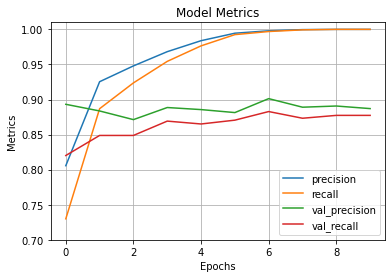

In [22]:
fig1 = plt.gcf()
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.axis(ymin=0.7,ymax=1.01)
plt.grid()
plt.title('Model Metrics')
plt.ylabel('Metrics')
plt.xlabel('Epochs')
plt.legend(['precision', 'recall', 'val_precision', 'val_recall'])
plt.show()

## Making predictions

/home/saksevul/.keras/datasets/flower_photos/roses/7376471712_e1be793f94.jpg
(1, 180, 180, 3)
[[3.1851868e-09 8.4016599e-11 9.9999201e-01 2.9894851e-09 8.0385898e-06]]
the predicted class is roses


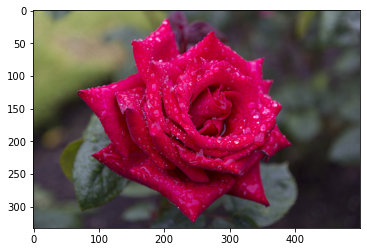

In [95]:
print(str(roses[10]))
plt.imshow(img.imread(str(roses[10])))

image=cv2.imread(str(roses[10]))
image_resized=cv2.resize(image,(img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

pred=resnet_model.predict(image)
print(pred)

output_class = class_names[np.argmax(pred)]
print('the predicted class is', output_class)